# Import Packages and Load CIFAR-10 Data

In [1]:
import torch, torchvision
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    download=False,
    # root="data",
    # download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    download=False,
    # root="data",
    # download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=2)

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


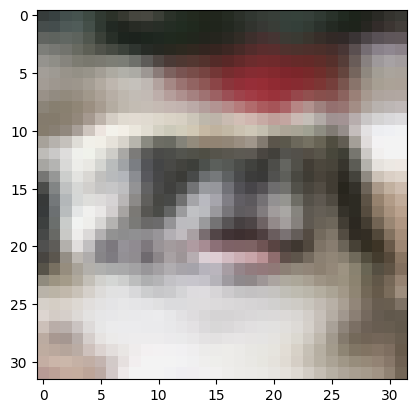

In [3]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

## Wrapping the pytorch data loaders to put the data onto the GPU

In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

# Build the Residual Neural Network

In [5]:
from torch import nn

class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):

        return self.downsample(self.norm(inputs))


class ConvNextBlock(nn.Module):

    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):

    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [6]:
model = Classifier(32, 4, 5).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [7]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [8]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

In [10]:
from tqdm import tqdm

train_acc_hist = []
val_acc_hist = []
train_loss_hist = []
val_loss_hist = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training & validation loss & accuracy
    # for training data - only once every 5 epochs (takes a while)
    # if j % 5 == 0:
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        train_acc_hist.append(acc)
        train_loss_hist.append(loss)
    
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        val_acc_hist.append(acc_val)
        val_loss_hist.append(loss_val)

Validate (train) Epoch 0: 100%|██████████| 313/313 [00:09<00:00, 34.07it/s]


Epoch 0: training loss: 2.068, accuracy: 23.909


Validate Epoch 0: 100%|██████████| 79/79 [00:02<00:00, 33.71it/s]


Epoch 0: validation loss: 2.069, accuracy: 23.873


Validate (train) Epoch 1: 100%|██████████| 313/313 [00:08<00:00, 34.81it/s]


Epoch 1: training loss: 1.969, accuracy: 29.413


Validate Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 34.11it/s]


Epoch 1: validation loss: 1.979, accuracy: 28.936


Validate (train) Epoch 2: 100%|██████████| 313/313 [00:09<00:00, 34.44it/s]


Epoch 2: training loss: 2.091, accuracy: 22.571


Validate Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 34.01it/s]


Epoch 2: validation loss: 2.091, accuracy: 22.567


Validate (train) Epoch 3: 100%|██████████| 313/313 [00:09<00:00, 34.26it/s]


Epoch 3: training loss: 1.818, accuracy: 35.548


Validate Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 34.13it/s]


Epoch 3: validation loss: 1.815, accuracy: 35.621


Validate (train) Epoch 4: 100%|██████████| 313/313 [00:09<00:00, 34.69it/s]


Epoch 4: training loss: 1.796, accuracy: 34.732


Validate Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 34.04it/s]


Epoch 4: validation loss: 1.787, accuracy: 34.375


Validate (train) Epoch 5: 100%|██████████| 313/313 [00:09<00:00, 34.38it/s]


Epoch 5: training loss: 1.712, accuracy: 38.097


Validate Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 33.93it/s]


Epoch 5: validation loss: 1.723, accuracy: 37.599


Validate (train) Epoch 6: 100%|██████████| 313/313 [00:09<00:00, 34.59it/s]


Epoch 6: training loss: 1.670, accuracy: 39.669


Validate Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 34.02it/s]


Epoch 6: validation loss: 1.674, accuracy: 38.617


Validate (train) Epoch 7: 100%|██████████| 313/313 [00:09<00:00, 34.17it/s]


Epoch 7: training loss: 1.609, accuracy: 42.325


Validate Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 33.72it/s]


Epoch 7: validation loss: 1.612, accuracy: 41.881


Validate (train) Epoch 8: 100%|██████████| 313/313 [00:09<00:00, 34.13it/s]


Epoch 8: training loss: 1.605, accuracy: 42.477


Validate Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 33.85it/s]


Epoch 8: validation loss: 1.607, accuracy: 42.158


Validate (train) Epoch 9: 100%|██████████| 313/313 [00:08<00:00, 34.98it/s]


Epoch 9: training loss: 1.565, accuracy: 44.202


Validate Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 33.73it/s]


Epoch 9: validation loss: 1.571, accuracy: 43.987


Validate (train) Epoch 14: 100%|██████████| 313/313 [00:09<00:00, 34.57it/s]


Epoch 14: training loss: 1.488, accuracy: 46.725


Validate Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 34.14it/s]


Epoch 14: validation loss: 1.494, accuracy: 46.282


Validate (train) Epoch 15: 100%|██████████| 313/313 [00:09<00:00, 34.32it/s]


Epoch 15: training loss: 1.562, accuracy: 44.207


Validate Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 34.23it/s]


Epoch 15: validation loss: 1.568, accuracy: 43.443


Validate (train) Epoch 16: 100%|██████████| 313/313 [00:08<00:00, 34.96it/s]


Epoch 16: training loss: 1.507, accuracy: 46.805


Validate Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 33.74it/s]


Epoch 16: validation loss: 1.512, accuracy: 45.619


Validate (train) Epoch 17: 100%|██████████| 313/313 [00:09<00:00, 34.31it/s]


Epoch 17: training loss: 1.475, accuracy: 46.850


Validate Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 33.78it/s]


Epoch 17: validation loss: 1.476, accuracy: 46.371


Validate (train) Epoch 18: 100%|██████████| 313/313 [00:09<00:00, 34.51it/s]


Epoch 18: training loss: 1.403, accuracy: 49.958


Validate Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 33.98it/s]


Epoch 18: validation loss: 1.407, accuracy: 49.486


Validate (train) Epoch 19: 100%|██████████| 313/313 [00:09<00:00, 34.30it/s]


Epoch 19: training loss: 1.398, accuracy: 49.958


Validate Epoch 19: 100%|██████████| 79/79 [00:02<00:00, 33.53it/s]


Epoch 19: validation loss: 1.398, accuracy: 49.960


Validate (train) Epoch 20: 100%|██████████| 313/313 [00:09<00:00, 34.52it/s]


Epoch 20: training loss: 1.384, accuracy: 50.509


Validate Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 34.21it/s]


Epoch 20: validation loss: 1.396, accuracy: 49.881


Validate (train) Epoch 21: 100%|██████████| 313/313 [00:09<00:00, 34.49it/s]


Epoch 21: training loss: 1.389, accuracy: 50.182


Validate Epoch 21: 100%|██████████| 79/79 [00:02<00:00, 33.58it/s]


Epoch 21: validation loss: 1.397, accuracy: 49.506


Validate (train) Epoch 22: 100%|██████████| 313/313 [00:09<00:00, 34.35it/s]


Epoch 22: training loss: 1.379, accuracy: 50.507


Validate Epoch 22: 100%|██████████| 79/79 [00:02<00:00, 33.94it/s]


Epoch 22: validation loss: 1.397, accuracy: 49.367


Validate (train) Epoch 23: 100%|██████████| 313/313 [00:09<00:00, 34.37it/s]


Epoch 23: training loss: 1.377, accuracy: 51.121


Validate Epoch 23: 100%|██████████| 79/79 [00:02<00:00, 34.19it/s]


Epoch 23: validation loss: 1.393, accuracy: 49.506


Validate (train) Epoch 24: 100%|██████████| 313/313 [00:08<00:00, 34.90it/s]


Epoch 24: training loss: 1.378, accuracy: 51.298


Validate Epoch 24: 100%|██████████| 79/79 [00:02<00:00, 33.37it/s]


Epoch 24: validation loss: 1.398, accuracy: 49.595


Validate (train) Epoch 25: 100%|██████████| 313/313 [00:09<00:00, 34.15it/s]


Epoch 25: training loss: 1.369, accuracy: 51.013


Validate Epoch 25: 100%|██████████| 79/79 [00:02<00:00, 33.87it/s]


Epoch 25: validation loss: 1.397, accuracy: 49.575


Validate (train) Epoch 26: 100%|██████████| 313/313 [00:09<00:00, 34.34it/s]


Epoch 26: training loss: 1.329, accuracy: 52.411


Validate Epoch 26: 100%|██████████| 79/79 [00:02<00:00, 33.61it/s]


Epoch 26: validation loss: 1.347, accuracy: 50.880


Validate (train) Epoch 27: 100%|██████████| 313/313 [00:09<00:00, 33.91it/s]


Epoch 27: training loss: 1.338, accuracy: 51.862


Validate Epoch 27: 100%|██████████| 79/79 [00:02<00:00, 33.28it/s]


Epoch 27: validation loss: 1.341, accuracy: 51.286


Validate (train) Epoch 28: 100%|██████████| 313/313 [00:09<00:00, 34.38it/s]


Epoch 28: training loss: 1.407, accuracy: 50.075


Validate Epoch 28: 100%|██████████| 79/79 [00:02<00:00, 33.84it/s]


Epoch 28: validation loss: 1.426, accuracy: 48.457


Validate (train) Epoch 29: 100%|██████████| 313/313 [00:09<00:00, 34.54it/s]


Epoch 29: training loss: 1.301, accuracy: 53.195


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 33.81it/s]

Epoch 29: validation loss: 1.318, accuracy: 52.383


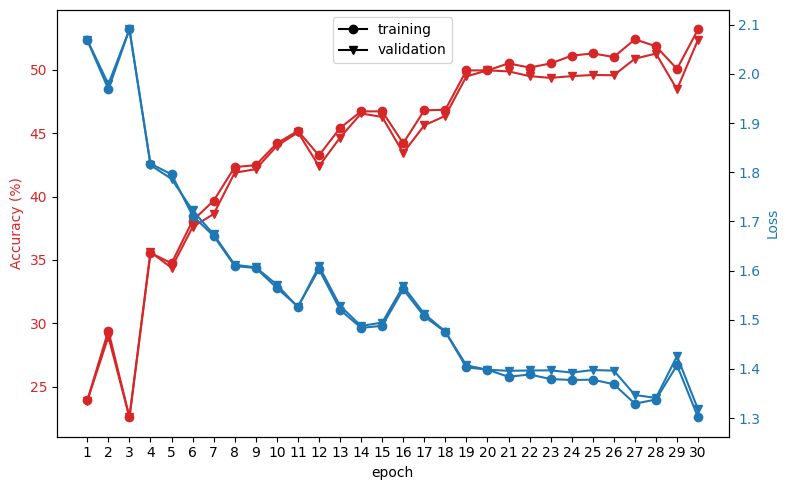

In [11]:
fig, ax1 = plt.subplots(figsize=(8,5))

epochX = range(1,epochs+1)
color = 'tab:red'
ax1.plot(np.nan, np.nan, marker='o', color="k", label="training")
ax1.plot(np.nan, np.nan, marker='v', color="k", label="validation")
ax1.legend(loc="upper center")
ax1.plot(epochX, train_acc_hist, marker='o', color=color)
ax1.plot(epochX, val_acc_hist, marker='v', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('epoch')
ax1.set_ylabel('Accuracy (%)', color=color)
ax1.set_xticks(epochX)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(epochX, train_loss_hist, marker='o', color=color)
ax2.plot(epochX, val_loss_hist, marker='v', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Discussion

As shown in the plot above, I was able to beat the original performance (validation loss: 1.442, accuracy: 47.627%) by increasing the "blocks per stage" from the default value of 2 up to 5. Clearly, this was not a significant improvement as I was only able to get to a validation loss of 1.318 and accuracy of 52.383%. I experimented with changing the other hyper-parameters suggested, such as the number of convolutions between downsampling and number of filters in each layers, but was unable to find an optimal set of values. 

I believe that increasing the blocks per stage improved the model accuracy by allowing the network to identify more complex features. The current model is probably still overfitting the data to some degree based on the training curve. When researching ResNets, I found that the blocks per stage is typically increased as the network depth is increased. For example, ResNet-18 and Res-34 have fewer blocks per stage than ResNet-50. Therefore, I think the most direct path towards further improving the model accuracy is to use a deeper network with an appropriate number of blocks per stage.

